NOTES:

   - multiple attachments upwards are 50% ubottu (documentation bot)
       otherwise: seems annotator was unsure of the real target, but probably same cluster anyway -> probbaly very annotator-dependent, do we have that info ? 
   - self-loops starts cluster, but crosses end of previous clusters (how much overlap?)
   - isolated self-loop probably its own class (short/smiley/etc)
   - some turns with no head acts as self-loops/beginning of clusters
   - server always self-loop ? -> no cluster
   - bcp de petits clusters (server, etc)
   - différence de longueur dans train (xx->500) vs dev (250) : problème ? 


In [1]:
import itertools
import sys
import logging
from typing import Any, Tuple, Dict, List, Iterable
import torch
import torch.optim as optim

In [2]:
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import Field, LabelField, TextField, ListField, SequenceLabelField
from allennlp.data.instance import Instance
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer, PretrainedBertIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WordTokenizer, PretrainedTransformerTokenizer
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding, PretrainedBertEmbedder
from allennlp.modules.seq2vec_encoders import BertPooler

from allennlp.modules import Seq2VecEncoder, Seq2SeqEncoder
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.data.vocabulary import Vocabulary

from allennlp.training.trainer import Trainer
from allennlp.data.iterators import BucketIterator
from allennlp.common import Params
from allennlp.nn import util

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#from dummy_chat_reader import ChatReader
from irc_chat_reader import ChatReader

In [5]:
token_indexers = {"tokens": SingleIdTokenIndexer()}

tokenizer_cfg = Params({"word_splitter": {"language": "en"}})

word_tokenizer = Tokenizer.from_params(tokenizer_cfg)

In [6]:
reader = ChatReader(
    tokenizer=word_tokenizer,
    token_indexers=token_indexers,
    raw = True,
    sub_sequence = None,
    #clip = 200
    )
train_instances = reader.read("../data/train")
dev_instances = reader.read("../data/dev")

153it [00:42,  2.92it/s]
10it [00:01,  7.90it/s]


In [7]:
vocab = Vocabulary.from_instances(train_instances+dev_instances)

100%|██████████| 163/163 [00:00<00:00, 163.98it/s]


In [8]:
#for i in train_instances:
#    #print(i)
#    i["lines"].index(vocab)
#    i["arcs"].index(vocab)
#    print(i["lines"].get_padding_lengths())

In [9]:
i0 = train_instances[0]
i0["is_server"].array[:10]

array([False,  True, False, False, False, False, False, False, False,
       False])

In [10]:
#while True:
#    pass

In [11]:
#sum([len([x for x in i["metadata"].metadata["addressees"] if x is None]) for i in train_instances])

In [12]:
c = 0
for n,i in enumerate(train_instances):
    nbarcs = len(i["arcs"].indices)
    if nbarcs==0: 
        c+=1 
        print(n)
print("nb of document with zeros edges:",c)

nb of document with zeros edges: 0


In [13]:
#distance max
#for instance in train_instances:
#    maxl = max([abs(j-i) for (i,j) in instance["arcs"].indices])
#    print(maxl)
               

In [14]:
from allennlp.models import Model
from typing import Dict, List, Iterable
from allennlp.modules import TimeDistributed
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits

In [15]:
dev_instances = reader.read("../data/dev")

10it [00:01,  7.90it/s]


In [16]:
# probing the gold annotations to see how many multiple attachements
def store_gold(instances,chat_id):
    gold = {}
    for (i,j) in instances[chat_id]["arcs"].indices:
        if i in gold:
            gold[i].append(j)
        else:
            gold[i] = [j]
    return gold

In [34]:
dev_gold = {i:store_gold(dev_instances,i) for i in range(len(dev_instances))}
train_gold = {i:store_gold(train_instances,i) for i in range(len(train_instances))}

In [18]:
chat_id = 0

In [19]:
# check multiple attachments
from collections import Counter
c = Counter([len(dev_gold[chat_id][i]) for i in dev_gold[chat_id]])
c

Counter({1: 243, 2: 5})

In [20]:
# print users for turns with multiple heads
all = []
for chat_id in range(len(dev_instances)):
    print("------",chat_id)
    for i in dev_gold[chat_id]: 
        if len(dev_gold[chat_id][i])>1:
            all.append((dev_instances[chat_id]["lines"][i].tokens[1]))
            print(all[-1])
print("total",len(all))        
Counter(all).most_common(10)

------ 0
ubottu
edbian
ubottu
ubottu
toad
------ 1
ubottu
ubottu
ubottu
Frantic
optiks
optiks
ubottu
ubottu
ubottu
ubottu
------ 2
ud
phill
CPayan
phill
------ 3
allsystemsarego
ActionParsnip1
ubottu
ActionParsnip1
ubottu
rookeeeeeeeee
sinuc
sken
sinuc
sken
sken
sken
ubottu
ubottu
ubottu
BoogieBoo
Panarchy
BoogieBoo
------ 4
jasoncohen
Raf99
f_newton
MartenH
Nevado
linlin
jasoncohen
MartenH
f_newton
CircleofChaos
f_newton
Agamotto
------ 5
ubottu
ubottu
eepberries
Nytrix
ubottu
ubottu
b1n42y
stevr1it
ubottu
ubottu
Silicium
Nytrix
ubottu
Nytrix
ubottu
ActionParsnip
rogerio
------ 6
nubbe
microhaxo
microhaxo
bob2
bob2
microhaxo
lukus001
xabbu|
CDK
microhaxo
floo
------ 7
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
ubottu
tstebut
------ 8
L1nuxRules
ubottu
bonhoffer
bonhoffer
OttScorp
bonhoffer
------ 9
corba
ubottu
ubottu
ubottu
corba
MonkeyDust
figure002
groob
total 105


[(ubottu, 40),
 (sken, 4),
 (microhaxo, 4),
 (f_newton, 3),
 (Nytrix, 3),
 (bonhoffer, 3),
 (optiks, 2),
 (phill, 2),
 (ActionParsnip1, 2),
 (sinuc, 2)]

In [36]:
def display_chat(instances,gold,chat_id,start=0,nb=250,file=sys.stdout):
    turn_key = "lines"
    for i,turn in enumerate(instances[chat_id][turn_key][start:start+nb]):
        k = i + start
        head = gold[chat_id].get(k,"NONE")
        if head == [k]: head = "SELF-LOOP"
        print(k,"->",head,turn.tokens,file=file)

In [37]:
display_chat(dev_instances,dev_gold,chat_id)

0 -> NONE [<, MWM, >, oh, jeeze, :, I, keep, crossing, what, you, are, saying, iun, my, head, ., I, got, it, mixed, up, again, and, was, right, the, first, time, ., I, do, nt, know, how, to, get, Windows, from, xubuntu, ..., only, xubuntu, from, windows, ., sorry]
1 -> [0] [<, corba, >, no, prob, :)]
2 -> SELF-LOOP [_, server, nicomach2s, is, now, known, as, nicomachus]
3 -> [0] [<, corba, >, i, ve, done, it, a, thousand, times, in, cinnamon, but, this, is, an, old, computer, and, i, have, to, use, xfce, or, lxde, ,, i, do, nt, know, if, i, can, run, mate, ...]
4 -> NONE [<, wafflejock, >, ah, yeah, the, shares, plugin, appears, to, be, for, adding, shared, folders, ,, might, be, useful, but, not, for, this, issue]
5 -> [3] [<, corba, >, not, only, that, ,, i, m, having, problems, downloading, it, form, the, ppa, haha]
6 -> [3] [<, wafflejock, >, corba, ,, you, try, running, thunar, from, the, command, line, and/or, watching, syslog, while, you, try, to, copy, /, paste, ?, might, give,

In [38]:
SAVE=FALSE

if SAVE:
    with open("log.chat","w") as f_out:
        for chat_id in range(len(dev_instances)):
            print("==============DEV CHAT nb %s ======="%chat_id,file=f_out)
            display_chat(dev_instances,dev_gold,chat_id,file=f_out)

NameError: name 'FALSE' is not defined

In [39]:
#sorted(dev_instances[0]["arcs"].indices)

In [42]:
from IPython.display import HTML as html_print
import pylab as plt

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

map = ["green","blue","yellow","red","gray",
       "magenta","olive","purple","lightblue","salmon",
       "orange","teal","tomato","black"]


def print_color(s,color="black"):
    display(html_print(cstr(s,color=color)))

def gen_color(map,nmax=30):
    i = 0
    c = 0
    nb = len(map)
    while c<nmax:
        yield map[i]
        i = i + 1
        if i==nb:
            i=0  
        c = c + 1
        
        
colors = list(gen_color(map,nmax=250))
#colors

In [43]:
#for i in gen_color(map): print_color("test",color=i)

In [44]:
def display_clusters(instances,gold,chat_id = 0):
    clusters = {}
    cid = -1
    result = []
    all_users = []
    for i,turn in enumerate(instances[chat_id]["lines"]):
        head = gold[chat_id].get(i,"None")
        user = turn.tokens[1]
        auto = (head[0]==i) # self-loop
        #print(i,head)
        if True:
            if auto or head=="None":
                cid += 1
                clusters[i] = cid
                if auto: 
                    symbol = "X"
                else:
                    symbol = "x"
            else:
                clusters[i] = clusters[head[0]]
                symbol = "■"
            color = colors[clusters[i]]
            result.append(cstr(symbol,color=color))
            if i%50==0:
                result.append("\n")
    return clusters, html_print("".join(result))


In [45]:
clusters, figure = display_clusters(dev_instances,dev_gold,1)
figure

(array([15.,  4.,  3.,  4.,  4.,  3.,  1.,  1.,  1.,  0.]),
 array([  1,   2,   3,   4,   5,  10,  20,  40,  60, 100, 250]),
 <BarContainer object of 10 artists>)

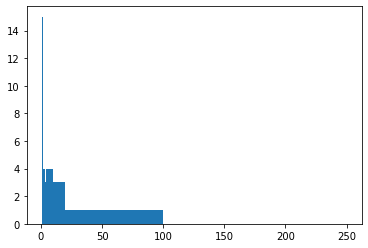

In [46]:
plt.hist(list((Counter(clusters.values()).values())),bins=[1,2,3,4,5,10,20,40,60,100,250])

In [47]:
for cid in range(10): 
    print("cluster ",cid,"---",end=" ")
    clusters, figure = display_clusters(dev_instances,dev_gold,cid)
    print(len(set(clusters.values()))," clusters found")
    display(figure)

cluster  0 --- 44  clusters found


cluster  1 --- 36  clusters found


cluster  2 --- 66  clusters found


cluster  3 --- 47  clusters found


cluster  4 --- 74  clusters found


cluster  5 --- 58  clusters found


cluster  6 --- 45  clusters found


cluster  7 --- 48  clusters found


cluster  8 --- 41  clusters found


cluster  9 --- 38  clusters found


(array([19.,  5.,  3.,  7.,  0.,  0.,  1.,  1.,  0.,  2.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

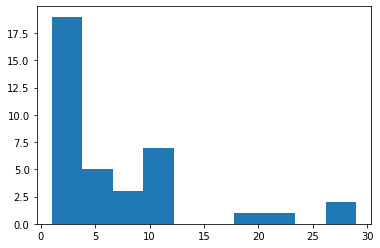

In [48]:
plt.hist(list((Counter(clusters.values()).values())))

In [49]:
display_chat(dev_instances,dev_gold,3)

0 -> NONE [<, joaopinto, >, internat1, ,, stat, file]
1 -> SELF-LOOP [<, ultratek, >, how, do, i, get, that, kool, icon, palette, at, the, botttom, of, my, screen, like, other, peeps, have]
2 -> [1] [<, allsystemsarego, >, ultratek, ,, AWN]
3 -> NONE [<, ActionParsnip1, >, ultratek, :, there, s, avant, -, window, -, navigator, kooldock, kiba, -, dock]
4 -> [3] [<, ActionParsnip1, >, ultratek, :, try, a, few, ,, see, which, you, like]
5 -> SELF-LOOP [*, Kondensuotas_pie, sweiki, kales]
6 -> [4] [<, ActionParsnip1, >, i, like, kooldock, if, i, HAD, to, have, one]
7 -> SELF-LOOP [<, Tex, -, Twil, >, Hello, ,, I, used, once, a, network, monitor, that, shows, via, a, web, gui, a, lot, of, information, about, the, network, traffic, per, host, (, bandwidth, ,, protocols, ,, data, transmitted, .., ), ., I, forgot, the, name, of, this, app, ,, anyone, ?]
8 -> [0] [<, internat1, >, joaopinto, :, i, m, told, that, wo, nt, work, for, what, i, want, .., ie, say, i, have, a, mnt, point, /home, /, sh

In [61]:
clusters, figure = display_clusters(train_instances,train_gold,100)
figure

In [60]:
print(len(set(clusters.values()))," clusters found")

215  clusters found


In [58]:
len(clusters)

499